# k-Nearest Neighbors

In [39]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## Data preprocessing

In [40]:
df = pd.read_csv("dataset.csv")
df.head()

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,353098,4,1,1,2,2,1,1,1,1,2
1,411359,1,1,1,1,2,1,1,1,1,2
2,411453,5,1,1,1,2,1,3,1,1,2
3,466901,1,1,1,1,2,1,1,1,1,2
4,474162,8,7,8,5,5,10,9,10,1,4


### a. Convert the classes to 0 (benign) and 1 (malignant)

In [41]:
df["class"] = df["class"].map({2: 0, 4: 1})
df.head()

,id,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,353098,4,1,1,2,2,1,1,1,1,0
1,411359,1,1,1,1,2,1,1,1,1,0
2,411453,5,1,1,1,2,1,3,1,1,0
3,466901,1,1,1,1,2,1,1,1,1,0
4,474162,8,7,8,5,5,10,9,10,1,1


### b. Fill missing values (with mode)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 699 non-null    int64 
 1   clump_thickness    699 non-null    int64 
 2   size_uniformity    699 non-null    int64 
 3   shape_uniformity   699 non-null    int64 
 4   marginal_adhesion  699 non-null    int64 
 5   epithelial_size    699 non-null    int64 
 6   bare_nucleoli      699 non-null    object
 7   bland_chromatin    699 non-null    int64 
 8   normal_nucleoli    699 non-null    int64 
 9   mitoses            699 non-null    int64 
 10  class              699 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 60.2+ KB


In [43]:
vals, counts = np.unique(df["bare_nucleoli"], return_counts=True)
print(vals, counts, sep="\n")
mode = vals[np.argmax(counts)]

['1' '10' '2' '3' '4' '5' '6' '7' '8' '9' '?']
[402 132  30  28  19  30   4   8  21   9  16]


In [44]:
df.loc[df["bare_nucleoli"] == "?", "bare_nucleoli"] = mode
df["bare_nucleoli"] = df["bare_nucleoli"].astype("int64")

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   id                 699 non-null    int64
 1   clump_thickness    699 non-null    int64
 2   size_uniformity    699 non-null    int64
 3   shape_uniformity   699 non-null    int64
 4   marginal_adhesion  699 non-null    int64
 5   epithelial_size    699 non-null    int64
 6   bare_nucleoli      699 non-null    int64
 7   bland_chromatin    699 non-null    int64
 8   normal_nucleoli    699 non-null    int64
 9   mitoses            699 non-null    int64
 10  class              699 non-null    int64
dtypes: int64(11)
memory usage: 60.2 KB


### c. Drop non-value added features

In [46]:
df.drop(columns="id", inplace=True)
df.head()

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,4,1,1,2,2,1,1,1,1,0
1,1,1,1,1,2,1,1,1,1,0
2,5,1,1,1,2,1,3,1,1,0
3,1,1,1,1,2,1,1,1,1,0
4,8,7,8,5,5,10,9,10,1,1


### d. Standardization

In [47]:
from sklearn.preprocessing import StandardScaler

df.iloc[:, :-1] = StandardScaler().fit_transform(df.iloc[:, :-1])
df.head()

,clump_thickness,size_uniformity,shape_uniformity,marginal_adhesion,epithelial_size,bare_nucleoli,bland_chromatin,normal_nucleoli,mitoses,class
0,-0.148465,-0.699995,-0.743299,-0.282780,-0.549561,-0.686979,-1.000471,-0.611825,-0.343912,0
1,-1.214667,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-1.000471,-0.611825,-0.343912,0
2,0.206936,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-0.179662,-0.611825,-0.343912,0
3,-1.214667,-0.699995,-0.743299,-0.633247,-0.549561,-0.686979,-1.000471,-0.611825,-0.343912,0
4,1.273138,1.267685,1.613773,0.768621,0.806239,1.799664,2.282766,2.337594,-0.343912,1


## Construct KNeighborsClassifier

### Split Train, Test, Validate set

In [48]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=1234)
validate_train_df, validate_df = train_test_split(train_df, test_size=0.2, random_state=1234)

In [49]:
from sklearn.neighbors import KNeighborsClassifier

### Manually tuning of k value with train-validate

[0.96428571 0.95535714 0.95535714 0.97321429 0.95535714 0.96428571
 0.97321429 0.97321429 0.97321429 0.97321429]
Highest accuracy at k=4


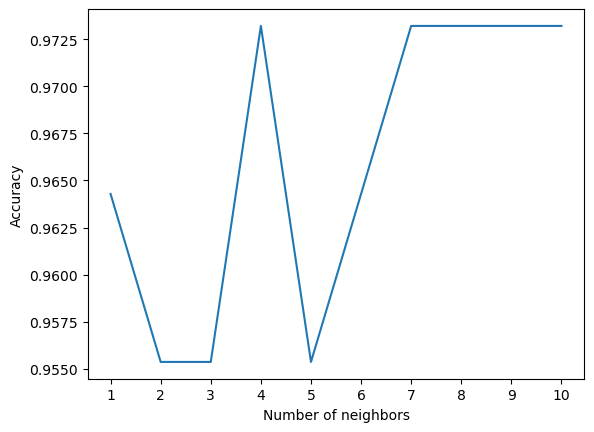

In [50]:
maxK = 10
accuracy = []
for k in range(1, maxK + 1):
    knn = KNeighborsClassifier(n_neighbors=k).fit(validate_train_df.iloc[:, :-1], validate_train_df.iloc[:, -1])
    accuracy.append(knn.score(validate_df.iloc[:, :-1], validate_df.iloc[:, -1]))
accuracy = np.array(accuracy)
print(accuracy)
print("Highest accuracy at k=", best_neighbors := (np.argmax(accuracy) + 1), sep="")
plt.plot(range(1, maxK + 1), accuracy)
plt.xticks(range(1, maxK + 1))
plt.xlabel("Number of neighbors")
plt.ylabel("Accuracy")
plt.show()

In [51]:
X_train, y_train = train_df.iloc[:, :-1], train_df.iloc[:, -1]
knn = KNeighborsClassifier(n_neighbors=best_neighbors).fit(X_train, y_train)
y_pred = knn.predict(test_df.iloc[:, :-1])
y_test = test_df.iloc[:, -1].values
knn

KNeighborsClassifier(n_neighbors=4)

#### Confusion Matrix

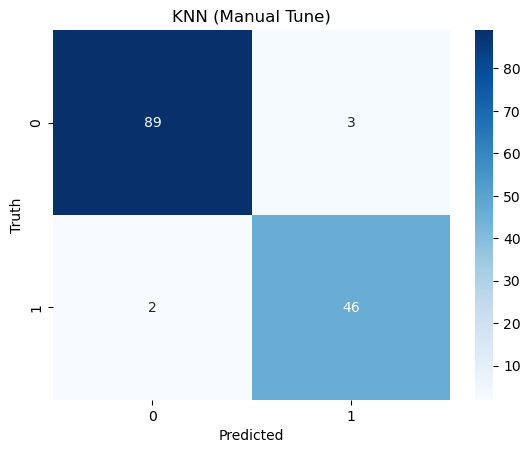

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        92
           1       0.94      0.96      0.95        48

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140



In [52]:
from sklearn.metrics import confusion_matrix, classification_report

confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion, fmt="g", annot=True, cmap="Blues")
plt.title("KNN (Manual Tune)")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()
print(classification_report(y_test, y_pred))

### Tuning the value of k using GridSearchCV

In [53]:
from sklearn.model_selection import GridSearchCV

parameters = {"n_neighbors": list(range(1, maxK + 1))}
gcv = GridSearchCV(KNeighborsClassifier(), parameters, scoring="accuracy")
gcv.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='accuracy')

[0.94810167 0.93018018 0.9659749  0.96240347 0.96240347 0.96238739
 0.96238739 0.9641731  0.96595882 0.9641731 ]
Highest accuracy at k=3


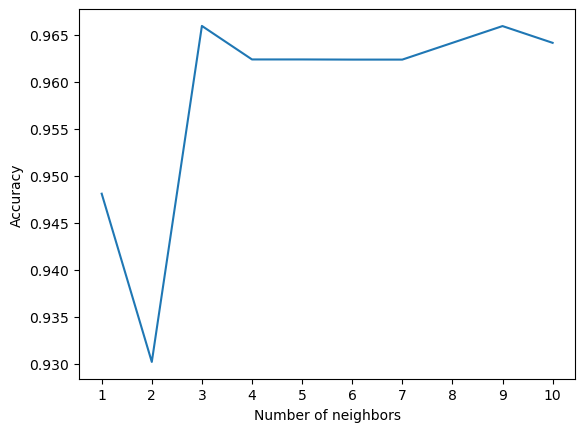

In [54]:
accuracy = gcv.cv_results_["mean_test_score"]
print(accuracy)
print("Highest accuracy at k=", np.argmax(accuracy) + 1, sep="")
plt.plot(range(1, maxK + 1), accuracy)
plt.xlabel("Number of neighbors")
plt.xticks(range(1, maxK + 1))
plt.ylabel("Accuracy")
plt.show()

In [55]:
knn = gcv.best_estimator_
knn

KNeighborsClassifier(n_neighbors=3)

In [56]:
knn = KNeighborsClassifier(n_neighbors=4).fit(X_train, y_train)
y_pred = knn.predict(test_df.iloc[:, :-1])
y_test = test_df.iloc[:, -1].values

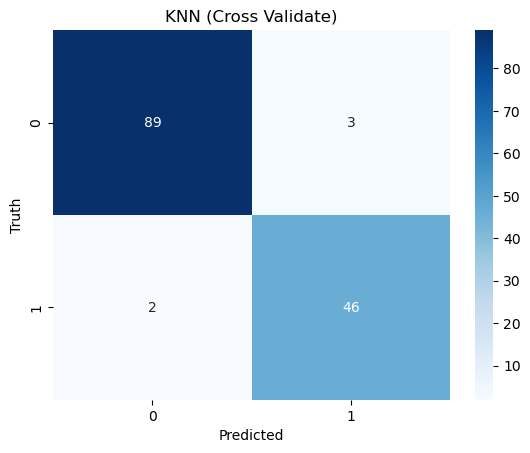

              precision    recall  f1-score   support

           0       0.98      0.97      0.97        92
           1       0.94      0.96      0.95        48

    accuracy                           0.96       140
   macro avg       0.96      0.96      0.96       140
weighted avg       0.96      0.96      0.96       140



In [57]:
confusion = confusion_matrix(y_test, y_pred)

sns.heatmap(confusion, fmt="g", annot=True, cmap="Blues")
plt.title("KNN (Cross Validate)")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()
print(classification_report(y_test, y_pred))